In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

class Const:
  """
  Constants

  Attributes
  ----------
  dataset_url : str
  """

  dataset_url = 'https://raw.githubusercontent.com/ssabrut/dataset/main/nlp/airline-sentiment.csv'
  PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')
  model = 'PDatt/airlinesentiment'

### Install Dependencies

In [2]:
%pip install sentence_transformers pinecone-client datasets seaborn matplotlib

from IPython.display import clear_output
clear_output()

### Load and Prepare Dataset

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv(Const.dataset_url)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# keep only the columns we need
df = df[['airline', 'airline_sentiment', 'text', 'tweet_created']]
df.head()

,airline,airline_sentiment,text,tweet_created
0,Virgin America,neutral,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,Virgin America,positive,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,Virgin America,neutral,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800
3,Virgin America,negative,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800
4,Virgin America,negative,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800


In [5]:
# check for any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline            14640 non-null  object
 1   airline_sentiment  14640 non-null  object
 2   text               14640 non-null  object
 3   tweet_created      14640 non-null  object
dtypes: object(4)
memory usage: 457.6+ KB


### Exploratory Data Analysis

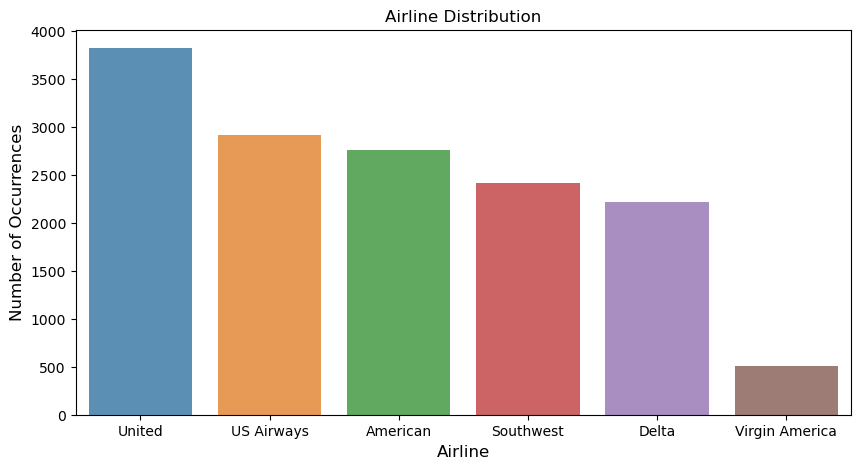

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

airlines = df['airline'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=airlines.index, y=airlines.values, alpha=0.8)
plt.title('Airline Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Airline', fontsize=12)
plt.show()

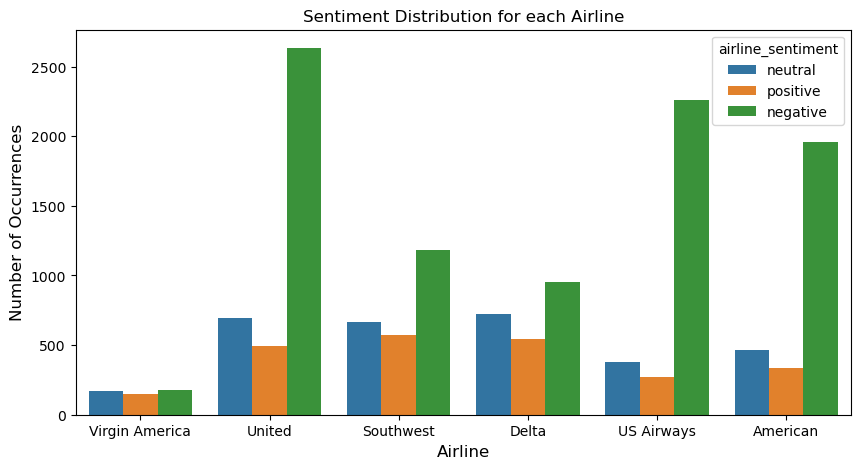

In [7]:
# now lets check the sentiment distribution for each airline
plt.figure(figsize=(10, 5))
sns.countplot(x='airline', hue='airline_sentiment', data=df)
plt.title('Sentiment Distribution for each Airline')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Airline', fontsize=12)
plt.show()

The bar chart provides a clear visual representation of customer sentiment towards different airlines. It highlights that US Airways and American have received a significantly higher number of negative reviews compared to others. This could indicate customer dissatisfaction with these airlines, possibly due to factors like service quality, punctuality, or pricing.

On the other hand, Virgin America, United, and Southwest have a more balanced sentiment distribution with a considerable amount of positive feedback. This suggests that customers generally have a more favorable opinion of these airlines.

Delta stands out with a high number of neutral reviews, indicating that customers might have a mixed opinion about their services.

In conclusion, this bar chart reveals critical insights into customer sentiment towards various airlines. These insights can guide strategic decisions for each airline – from improving customer service for airlines with negative reviews to maintaining the quality for airlines with positive feedback. It offers valuable perspectives for stakeholders aiming to enhance customer satisfaction and loyalty.

### Modeling

We will use a airlinesentiment model fine-tuned for sentiment analysis to analyze the hotel reviews. The model can be loaded from the HuggingFace model hub as follows:

In [8]:
import torch

# set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('The device is:', device)

The device is: cuda


In [9]:
from transformers import (
  pipeline,
  AutoTokenizer, 
  AutoModelForSequenceClassification
)

# load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(Const.model, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(Const.model)

# create a pipeline
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=device)

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

The sentiment analysis model returns LABEL_0 for negative, LABEL_1 for neutral and LABEL_2 for positive labels. We can add them to a dictionary to easily access them when showing the results.

In [10]:
labels = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

In [12]:
# test the pipeline
index = np.random.randint(0, len(df) - 1)
test_review = df['text'][index]
test_sentiment = df['airline_sentiment'][index]
print('Review:', test_review)
print('Sentiment:', test_sentiment)

Review: @AmericanAir I love very much your planes, can you please follow me back? It's an amazing bussines!
Sentiment: positive


In [13]:
# test the pipeline
classifier(test_review)

[{'label': 'LABEL_2', 'score': 0.9999316930770874}]

Our pipeline is working as expected and accurately predicts the correct label for the review.